* Набор данных с датчиков городских очистных сооружений сточных вод
* Цель - кластеризовать рабочее состояние установки для прогнозирования неисправностей с помощью алгоритмов k-means++ и dbscan
* water-treatment.data - выборка данных
water-treatment.names - в разделе 9 содержится разбиение по 13 кластерам, которое можно использовать для подбора метрики расстояния и теста

In [137]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from google.colab import files

import seaborn as sns
import matplotlib.pyplot as plt

import os

def uploadddd():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
files1 = { 'data': 'water-treatment.data', 'classes': 'classes.txt'}

for f in files1:
  file = files1[f]
  
  while True:
    print('select', file)
    if  os.path.isfile(file):
      break
    uploadddd()
    



select water-treatment.data
select classes.txt


In [138]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [139]:
header = 'Q-E,ZN-E,PH-E,DBO-E,DQO-E,SS-E,SSV-E,SED-E,COND-E,PH-P,DBO-P,SS-P,SSV-P,SED-P,COND-P,PH-D,DBO-D,DQO-D,SS-D,SSV-D,SED-D,COND-D,PH-S,DBO-S,DQO-S,SS-S,SSV-S,SED-S,COND-S,RD-DBO-P,RD-SS-P,RD-SED-P,RD-DBO-S,RD-DQO-S,RD-DBO-G,RD-DQO-G,RD-SS-G,RD-SED-G'.split(',')
df = pd.read_csv(files1['data'], delimiter=",", names = header)
# df = pd.read_csv(files1['data'], delimiter=",", header=None)
df = df.replace('?', np.NaN)
df

,Q-E,ZN-E,PH-E,DBO-E,DQO-E,SS-E,SSV-E,SED-E,COND-E,PH-P,DBO-P,SS-P,SSV-P,SED-P,COND-P,PH-D,DBO-D,DQO-D,SS-D,SSV-D,SED-D,COND-D,PH-S,DBO-S,DQO-S,SS-S,SSV-S,SED-S,COND-S,RD-DBO-P,RD-SS-P,RD-SED-P,RD-DBO-S,RD-DQO-S,RD-DBO-G,RD-DQO-G,RD-SS-G,RD-SED-G
D-1/3/90,44101,1.50,7.8,NaN,407,166,66.3,4.5,2110,7.9,NaN,228,70.2,5.5,2120,7.9,NaN,280,94,72.3,0.3,2010,7.3,NaN,84,21,81.0,0.02,2000,NaN,58.8,95.5,NaN,70.0,NaN,79.4,87.3,99.6
D-2/3/90,39024,3.00,7.7,NaN,443,214,69.2,6.5,2660,7.7,NaN,244,75.4,7.7,2570,7.6,NaN,474,96,79.2,0.4,2700,7.5,NaN,91,17,94.1,0.00,2590,NaN,60.7,94.8,NaN,80.8,NaN,79.5,92.1,100
D-4/3/90,32229,5.00,7.6,NaN,528,186,69.9,3.4,1666,7.7,NaN,220,72.7,4.5,1594,7.7,NaN,272,92,78.3,0.2,1742,7.6,NaN,128,21,81,0.05,1888,NaN,58.2,95.6,NaN,52.9,NaN,75.8,88.7,98.5
D-5/3/90,35023,3.50,7.9,205,588,192,65.6,4.5,2430,7.8,236,268,73.1,8.5,2280,7.8,158,376,96,77.1,0.4,2060,7.6,20,104,20,96.7,0.00,1840,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100
D-6/3/90,36924,1.50,8.0,242,496,176,64.8,4.0,2110,7.9,NaN,236,57.6,4.5,2020,7.8,NaN,372,88,68.2,0.2,2250,7.6,19,108,22,65.9,0.02,2120,NaN,62.7,95.6,NaN,71.0,92.1,78.2,87.5,99.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D-26/8/91,32723,0.16,7.7,93,252,176,56.8,2.3,894,7.7,108,146,65.8,3.0,873,7.7,63,224,55,78.2,0.2,915,7.9,19,54,6,100,0.01,942,NaN,62.3,93.3,69.8,75.9,79.6,78.6,96.6,99.6
D-27/8/91,33535,0.32,7.8,192,346,172,68.6,4.0,988,7.8,210,192,68.8,4.5,991,7.7,100,215,80,73.8,0.1,966,7.9,17,88,16,90.0,0.00,950,NaN,58.3,97.8,83.0,59.1,91.1,74.6,90.7,100
D-28/8/91,32922,0.30,7.4,139,367,180,64.4,3.0,1060,7.5,163,200,63.0,3.5,1040,7.6,105,250,70,85.7,0.1,1152,7.7,25,84,20,84.0,0.02,1136,NaN,65.0,97.1,76.2,66.4,82.0,77.1,88.9,99
D-29/8/91,32190,0.30,7.3,200,545,258,65.1,4.0,1260,7.4,191,226,67.3,3.5,1198,7.5,115,244,77,76.6,0.1,1351,7.7,21,71,27,71.1,0.01,1326,39.8,65.9,97.1,81.7,70.9,89.5,87.0,89.5,99.8


In [140]:
# fix to int
to_fix = [c for c in df.columns if df[c].dtype.name == 'object']
for c in to_fix:
  df[c] = pd.to_numeric(df[c].astype(str), errors='coerce')

In [141]:
# ???
# water_data.dropna(thresh=water_data.shape[0]*0.6,how='all',axis=1)

In [142]:
# parce classes
import datetime

with open(files1['classes'], 'r') as file:
    text = file.read()

classes = {}
text = text.split('\n\n')
for group in text:
    tmp = group.split('\n')
    class_name = tmp[0]
    del tmp[0]
    dates = ''.join(tmp).split(',')

    dates = [e.strip() for e in dates]

    if class_name in classes:
        classes[class_name].extend(dates)
    else:
        classes[class_name] = dates


    # print(f'{class_name}: {str(dates)}')

template = 'D-%d/%m/%y'

for c in classes:
    for day in classes[c]:
        if ' to ' in day:
            # print(day)
            temp = day.split(' to ')
            begin = temp[0].strip()
            end = temp[1].strip()
            # print(f'{begin} {end}')

            begin_dt = datetime.datetime.strptime(begin, template)
            end_dt = datetime.datetime.strptime(end, template)
            # print(f'{str(begin_dt)} ! {str(end_dt)}')
            delta = end_dt - begin_dt
            # print(delta)

            sub_array = []
            for dddd in range(delta.days+1):
                res = begin_dt + datetime.timedelta(days=dddd)
                sstr = 'D-{d.day}/{d.month}/'.format(d=res)
                sstr += res.strftime('%y')
                sub_array.append(sstr)
                # print(sstr)
            i = classes[c].index(day)
            del classes[c][i]
            classes[c][i:i] = sub_array
            # print()

for c in classes:
    for date in classes[c]:
        if len(date) > 10:
            print('!!!', c, date)

for c in classes:
    print(f'{c} -> {str(classes[c])}')


Normal situation -> ['D-1/3/90', 'D-2/3/90', 'D-3/3/90', 'D-4/3/90', 'D-5/3/90', 'D-6/3/90', 'D-7/3/90', 'D-8/3/90', 'D-9/3/90', 'D-10/3/90', 'D-11/3/90', 'D-12/3/90', 'D-16/3/90', 'D-17/3/90', 'D-18/3/90', 'D-19/3/90', 'D-20/3/90', 'D-21/3/90', 'D-22/3/90', 'D-23/3/90', 'D-24/3/90', 'D-25/3/90', 'D-26/3/90', 'D-27/3/90', 'D-28/3/90', 'D-29/3/90', 'D-30/3/90', 'D-1/2/90', 'D-2/2/90', 'D-3/2/90', 'D-4/2/90', 'D-5/2/90', 'D-6/2/90', 'D-7/2/90', 'D-8/2/90', 'D-9/2/90', 'D-10/2/90', 'D-11/2/90', 'D-12/2/90', 'D-13/2/90', 'D-14/2/90', 'D-15/2/90', 'D-16/2/90', 'D-17/2/90', 'D-18/2/90', 'D-19/2/90', 'D-21/2/90', 'D-22/2/90', 'D-23/2/90', 'D-24/2/90', 'D-25/2/90', 'D-26/2/90', 'D-27/2/90', 'D-28/2/90', 'D-1/1/90', 'D-2/1/90', 'D-3/1/90', 'D-4/1/90', 'D-5/1/90', 'D-6/1/90', 'D-7/1/90', 'D-8/1/90', 'D-9/1/90', 'D-10/1/90', 'D-11/1/90', 'D-12/1/90', 'D-13/1/90', 'D-14/1/90', 'D-15/1/90', 'D-16/1/90', 'D-17/1/90', 'D-18/1/90', 'D-19/1/90', 'D-20/1/90', 'D-21/1/90', 'D-22/1/90', 'D-23/1/90', 'D-24

In [143]:
# restructure class
classes_list = list(classes)
classes.items()
classes2 = {}
classes_description = {}
for k,v in classes.items():
  classes_description[classes_list.index(k)] = k
  for val in v:
    classes2[val] = classes_list.index(k)
# classes2

добавил даты из файла с классами, оказалось, что им не соответствуют данные, разбираюсь..

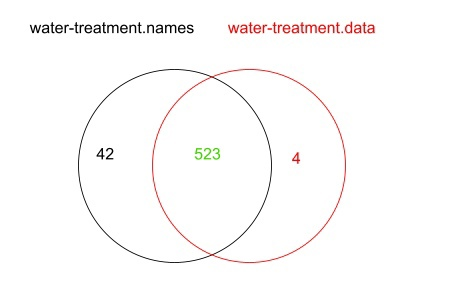  


In [144]:
not_intersection = [item for item in df.index if item not in classes2]
not_intersection.extend([item for item in classes2 if item not in df.index])

df_indexes = df.index
for d in not_intersection:
  s = d
  if d in classes2:
    s = s + ' !'
    del classes2[d]
  if d in df_indexes:
    s = s + ' ?'
    df.drop([d], inplace=True)
  # print(s)

# not_intersection

In [145]:
# add class names
for d in classes2:
  # print(d)
  elem = classes2[d]
  df.loc[d, 'class_index'] = elem
  # df.loc[d, 'class_name'] = classes_description[elem]

# df['class_n'] = pd.to_numeric(df[c], errors='coerce')
df

,Q-E,ZN-E,PH-E,DBO-E,DQO-E,SS-E,SSV-E,SED-E,COND-E,PH-P,DBO-P,SS-P,SSV-P,SED-P,COND-P,PH-D,DBO-D,DQO-D,SS-D,SSV-D,SED-D,COND-D,PH-S,DBO-S,DQO-S,SS-S,SSV-S,SED-S,COND-S,RD-DBO-P,RD-SS-P,RD-SED-P,RD-DBO-S,RD-DQO-S,RD-DBO-G,RD-DQO-G,RD-SS-G,RD-SED-G,class_index
D-1/3/90,44101.0,1.50,7.8,NaN,407.0,166.0,66.3,4.5,2110,7.9,NaN,228,70.2,5.5,2120,7.9,NaN,280.0,94.0,72.3,0.3,2010,7.3,NaN,84.0,21.0,81.0,0.02,2000.0,NaN,58.8,95.5,NaN,70.0,NaN,79.4,87.3,99.6,0.0
D-2/3/90,39024.0,3.00,7.7,NaN,443.0,214.0,69.2,6.5,2660,7.7,NaN,244,75.4,7.7,2570,7.6,NaN,474.0,96.0,79.2,0.4,2700,7.5,NaN,91.0,17.0,94.1,0.00,2590.0,NaN,60.7,94.8,NaN,80.8,NaN,79.5,92.1,100.0,0.0
D-4/3/90,32229.0,5.00,7.6,NaN,528.0,186.0,69.9,3.4,1666,7.7,NaN,220,72.7,4.5,1594,7.7,NaN,272.0,92.0,78.3,0.2,1742,7.6,NaN,128.0,21.0,81.0,0.05,1888.0,NaN,58.2,95.6,NaN,52.9,NaN,75.8,88.7,98.5,0.0
D-5/3/90,35023.0,3.50,7.9,205.0,588.0,192.0,65.6,4.5,2430,7.8,236.0,268,73.1,8.5,2280,7.8,158.0,376.0,96.0,77.1,0.4,2060,7.6,20.0,104.0,20.0,96.7,0.00,1840.0,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100.0,0.0
D-6/3/90,36924.0,1.50,8.0,242.0,496.0,176.0,64.8,4.0,2110,7.9,NaN,236,57.6,4.5,2020,7.8,NaN,372.0,88.0,68.2,0.2,2250,7.6,19.0,108.0,22.0,65.9,0.02,2120.0,NaN,62.7,95.6,NaN,71.0,92.1,78.2,87.5,99.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D-26/8/91,32723.0,0.16,7.7,93.0,252.0,176.0,56.8,2.3,894,7.7,108.0,146,65.8,3.0,873,7.7,63.0,224.0,55.0,78.2,0.2,915,7.9,19.0,54.0,6.0,100.0,0.01,942.0,NaN,62.3,93.3,69.8,75.9,79.6,78.6,96.6,99.6,8.0
D-27/8/91,33535.0,0.32,7.8,192.0,346.0,172.0,68.6,4.0,988,7.8,210.0,192,68.8,4.5,991,7.7,100.0,215.0,80.0,73.8,0.1,966,7.9,17.0,88.0,16.0,90.0,0.00,950.0,NaN,58.3,97.8,83.0,59.1,91.1,74.6,90.7,100.0,0.0
D-28/8/91,32922.0,0.30,7.4,139.0,367.0,180.0,64.4,3.0,1060,7.5,163.0,200,63.0,3.5,1040,7.6,105.0,250.0,70.0,85.7,0.1,1152,7.7,25.0,84.0,20.0,84.0,0.02,1136.0,NaN,65.0,97.1,76.2,66.4,82.0,77.1,88.9,99.0,8.0
D-29/8/91,32190.0,0.30,7.3,200.0,545.0,258.0,65.1,4.0,1260,7.4,191.0,226,67.3,3.5,1198,7.5,115.0,244.0,77.0,76.6,0.1,1351,7.7,21.0,71.0,27.0,71.1,0.01,1326.0,39.8,65.9,97.1,81.7,70.9,89.5,87.0,89.5,99.8,0.0


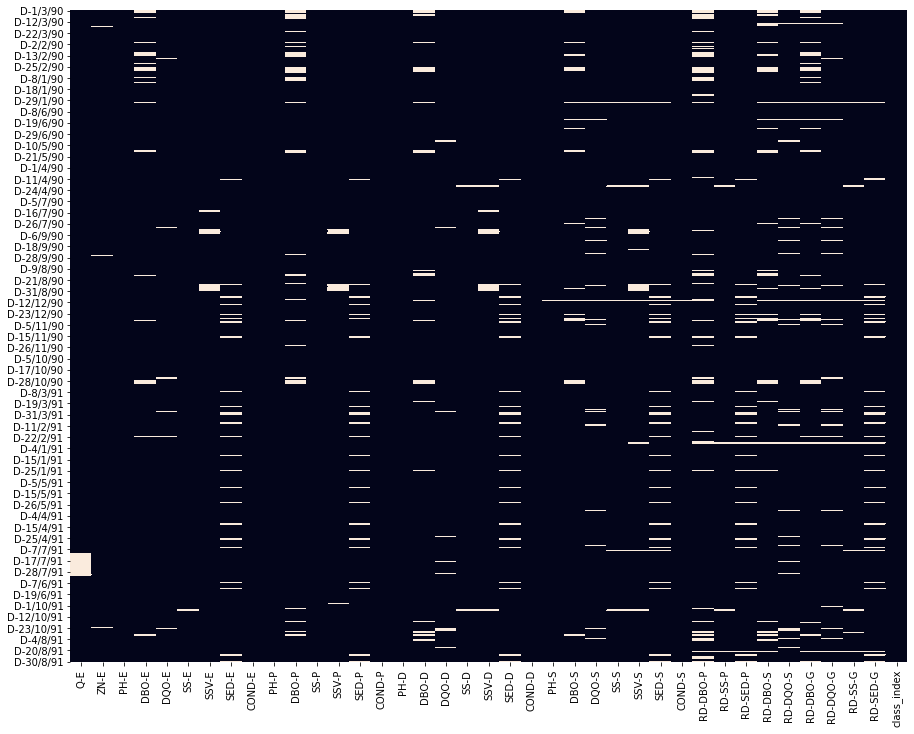

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 12))
pic = sns.heatmap(df.isnull(), cbar=False)
pic

In [147]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing}) # 'column_name': df.columns
missing_value_df


,percent_missing
Q-E,3.441683
ZN-E,0.573614
PH-E,0.000000
DBO-E,4.397706
DQO-E,1.147228
SS-E,0.191205
SSV-E,2.103250
SED-E,4.780115
COND-E,0.000000
PH-P,0.000000


In [148]:
more_then_30 = missing_value_df.loc[(missing_value_df['percent_missing'] > 30)]
more_then_30

,percent_missing


In [149]:
# раз нет столбцов с NaN более 30% - заполняю
df = df.fillna(df.median(axis=0))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523 entries, D-1/3/90 to D-30/8/91
Data columns (total 39 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Q-E          523 non-null    float64
 1   ZN-E         523 non-null    float64
 2   PH-E         523 non-null    float64
 3   DBO-E        523 non-null    float64
 4   DQO-E        523 non-null    float64
 5   SS-E         523 non-null    float64
 6   SSV-E        523 non-null    float64
 7   SED-E        523 non-null    float64
 8   COND-E       523 non-null    int64  
 9   PH-P         523 non-null    float64
 10  DBO-P        523 non-null    float64
 11  SS-P         523 non-null    int64  
 12  SSV-P        523 non-null    float64
 13  SED-P        523 non-null    float64
 14  COND-P       523 non-null    int64  
 15  PH-D         523 non-null    float64
 16  DBO-D        523 non-null    float64
 17  DQO-D        523 non-null    float64
 18  SS-D         523 non-null    float64
 19  

найти корреляцию и выпилить как в 1 лабе

In [150]:
def draw_corr():
  import seaborn as sns
  from matplotlib import pyplot
  %matplotlib inline
  corr = df.corr(method='pearson')

  a4_dims = (11.7, 8.27)
  _, ax = pyplot.subplots(figsize=a4_dims)

  sns.heatmap(corr, 
          xticklabels=corr.columns,
          yticklabels=corr.columns,
          ax=ax)


In [151]:
# find and delete columns with corr>0.95 
# AUTO
corr_dict = {}

corr = df.corr(method='pearson')
for x in corr:
  for y in corr[x].index:
    local_corr = corr[x][y]

    if np.isnan(local_corr) or local_corr is np.NaN or local_corr is None:
      continue

    if abs(local_corr) < 0.95:
      continue

    if x == y:
      continue

    # str = f'{x}:{y} = {local_corr}'
    # print(str)

    if y in corr_dict and x in corr_dict[y]:
      #print('piu')
      continue

    if x in corr_dict:
      corr_dict[x].append(y)
    else:
      corr_dict[x] = [y]

# corr_dict
print(corr_dict)
dublicate_columns = []
for key, value in corr_dict.items():
  dublicate_columns.extend(value)
dublicate_columns = list(set(dublicate_columns)) # clear dublicates


{'COND-E': ['COND-P'], 'SED-S': ['RD-SED-G']}


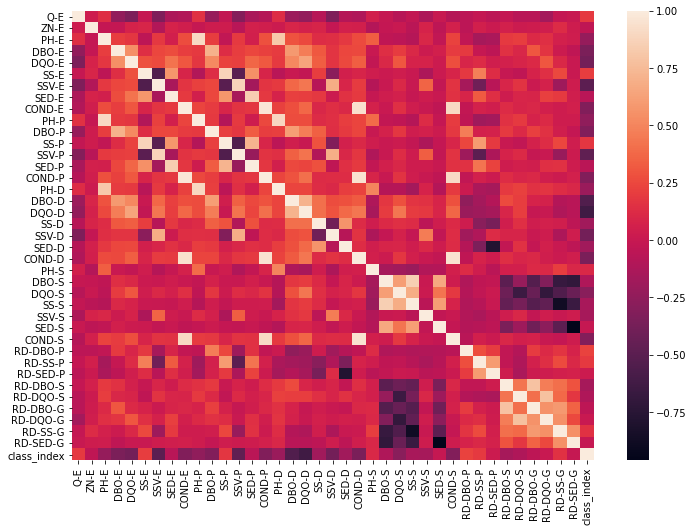

In [152]:
draw_corr()

In [153]:
df.corr(method='pearson')

,Q-E,ZN-E,PH-E,DBO-E,DQO-E,SS-E,SSV-E,SED-E,COND-E,PH-P,DBO-P,SS-P,SSV-P,SED-P,COND-P,PH-D,DBO-D,DQO-D,SS-D,SSV-D,SED-D,COND-D,PH-S,DBO-S,DQO-S,SS-S,SSV-S,SED-S,COND-S,RD-DBO-P,RD-SS-P,RD-SED-P,RD-DBO-S,RD-DQO-S,RD-DBO-G,RD-DQO-G,RD-SS-G,RD-SED-G,class_index
Q-E,1.000000,0.029237,0.139508,-0.245343,-0.338249,-0.006878,-0.324835,-0.121526,-0.095545,0.153077,-0.220410,-0.025566,-0.302025,-0.133937,-0.085102,0.127217,-0.199650,-0.238077,-0.073696,-0.329752,-0.080308,-0.107962,0.050929,-0.008811,-0.078237,-0.025729,-0.118034,-0.000135,-0.084850,-0.049678,-0.017253,-0.053832,-0.013424,-0.067107,-0.069093,-0.160666,-0.015886,-0.001092,0.193610
ZN-E,0.029237,1.000000,-0.013694,-0.015804,0.079311,0.092866,-0.096393,0.079499,0.047706,-0.004429,0.030806,0.032320,-0.065719,0.059528,0.044983,0.027250,0.095843,0.069779,0.087341,-0.016672,0.059574,0.054791,-0.091689,-0.017522,0.004778,-0.057699,0.079864,-0.041800,0.064262,-0.056028,0.056028,0.018480,0.061942,0.021289,0.033396,0.043599,0.122171,0.032209,-0.036418
PH-E,0.139508,-0.013694,1.000000,0.205236,0.180469,-0.043925,0.186334,0.057047,0.269812,0.902938,0.208757,-0.029652,0.188680,0.053229,0.281226,0.821203,0.292535,0.255567,0.130768,0.136139,0.186295,0.262397,0.334122,-0.034518,-0.050806,-0.085300,0.097785,-0.026769,0.230954,-0.030314,-0.149064,-0.132449,0.190638,0.210920,0.116988,0.144962,0.062584,0.035808,-0.230922
DBO-E,-0.245343,-0.015804,0.205236,1.000000,0.547955,0.141208,0.245688,0.269847,0.207067,0.192881,0.707303,0.133348,0.207251,0.247801,0.224301,0.202604,0.588857,0.467034,0.316333,0.172197,0.247061,0.249594,0.009928,0.135530,0.202736,0.104231,0.023497,0.051781,0.199269,0.189928,-0.009392,-0.048640,0.156691,0.101487,0.308224,0.167152,0.019960,-0.037729,-0.346853
DQO-E,-0.338249,0.079311,0.180469,0.547955,1.000000,0.283213,0.259373,0.424256,0.310075,0.174399,0.524505,0.232710,0.218133,0.370322,0.314575,0.188580,0.512660,0.644448,0.334359,0.172783,0.252340,0.334327,-0.018984,0.105510,0.309522,0.079406,0.074122,0.020355,0.278318,0.091342,0.125523,0.048697,0.063968,0.083254,0.112862,0.310306,0.105998,0.007601,-0.382930
SS-E,-0.006878,0.092866,-0.043925,0.141208,0.283213,1.000000,-0.541426,0.572588,0.088443,-0.096635,0.127522,0.876378,-0.496938,0.550967,0.084870,-0.068946,0.006506,-0.021544,0.208773,-0.273443,0.052540,0.084480,0.039159,0.017795,0.036334,0.007316,-0.118987,0.012441,0.083362,0.183012,0.475785,0.128991,-0.010080,-0.037645,0.076215,0.146960,0.255059,0.006563,0.204479
SSV-E,-0.324835,-0.096393,0.186334,0.245688,0.259373,-0.541426,1.000000,-0.136467,0.169576,0.220946,0.242026,-0.501774,0.870757,-0.156283,0.167192,0.191916,0.378254,0.440098,-0.078372,0.682347,0.092258,0.197012,-0.080739,0.008743,0.105588,-0.002499,0.358321,-0.019579,0.162931,-0.149039,-0.397077,-0.065261,0.091100,0.159553,0.018783,0.067488,-0.187361,0.029534,-0.489236
SED-E,-0.121526,0.079499,0.057047,0.269847,0.424256,0.572588,-0.136467,1.000000,0.188949,0.051474,0.246867,0.573392,-0.144124,0.846521,0.183851,0.079529,0.216276,0.209473,0.186730,0.024775,0.156990,0.189901,-0.003835,0.035856,0.061761,-0.003924,0.027814,0.012176,0.157475,0.081392,0.320706,0.140385,0.033890,0.093337,0.084939,0.215889,0.195429,0.046543,-0.064763
COND-E,-0.095545,0.047706,0.269812,0.207067,0.310075,0.088443,0.169576,0.188949,1.000000,0.238273,0.197941,0.093839,0.162900,0.177088,0.972786,0.225786,0.277273,0.376947,0.102867,0.135464,0.108777,0.939317,0.073282,0.009021,0.149772,0.036100,0.001075,-0.037162,0.901053,-0.025589,0.070539,0.048823,0.125437,0.083832,0.100986,0.056790,0.029611,0.054617,-0.317086
PH-P,0.153077,-0.004429,0.902938,0.192881,0.174399,-0.096635,0.220946,0.051474,0.238273,1.000000,0.194674,-0.090622,0.193964,0.029152,0.252289,0.894201,0.266849,0.266571,0.125479,0.145339,0.204023,0.240078,0.388738,-0.024141,-0.034871,-0.083160,0.124575,-0.011134,0.201021,-0.036006,-0.184753,-0.160619,0.156261,0.191291,0.074855,0.115785,0.031788,0.028714,-0.248705


In [154]:
# corr table
print(len(list(df)))
df.corr(method='pearson')[df.corr(method='pearson').abs() > 0.95]

39


,Q-E,ZN-E,PH-E,DBO-E,DQO-E,SS-E,SSV-E,SED-E,COND-E,PH-P,DBO-P,SS-P,SSV-P,SED-P,COND-P,PH-D,DBO-D,DQO-D,SS-D,SSV-D,SED-D,COND-D,PH-S,DBO-S,DQO-S,SS-S,SSV-S,SED-S,COND-S,RD-DBO-P,RD-SS-P,RD-SED-P,RD-DBO-S,RD-DQO-S,RD-DBO-G,RD-DQO-G,RD-SS-G,RD-SED-G,class_index
Q-E,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZN-E,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PH-E,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DBO-E,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQO-E,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SS-E,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSV-E,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SED-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COND-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.972786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PH-P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
print(corr_dict)
print(f'columns with abs(corr) > 0.95 found {dublicate_columns}')
df.drop(dublicate_columns, axis=1, inplace=True)

{'COND-E': ['COND-P'], 'SED-S': ['RD-SED-G']}
columns with abs(corr) > 0.95 found ['COND-P', 'RD-SED-G']


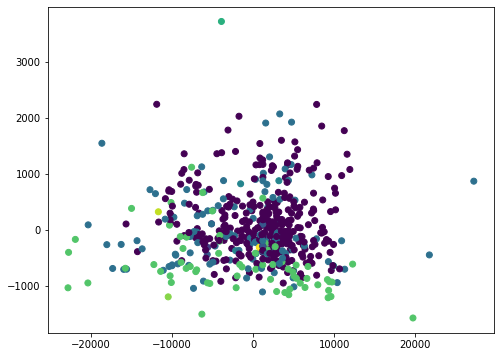

In [156]:
from sklearn.decomposition import PCA

x_pca = PCA(n_components=2).fit_transform(df)
plt.figure(2, figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=list(df['class_index']))


In [157]:
class_index = list(df['class_index'])

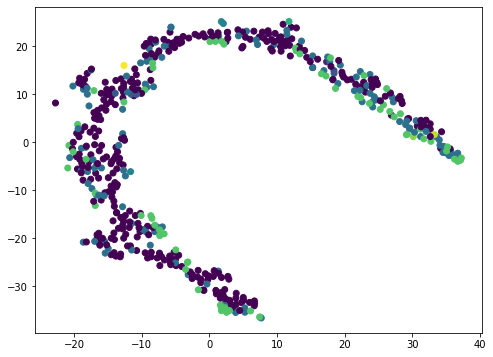

In [158]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2).fit_transform(df)

plt.figure(2, figsize=(8, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=class_index)

Шкалирую

In [159]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
index = df.index

df_not_scaled = df
df = pd.DataFrame(scaler.fit_transform(df.values), index=index, columns=list(df))
# df = pd.DataFrame(scaler.fit_transform(df.values))

In [160]:
df

,Q-E,ZN-E,PH-E,DBO-E,DQO-E,SS-E,SSV-E,SED-E,COND-E,PH-P,DBO-P,SS-P,SSV-P,SED-P,PH-D,DBO-D,DQO-D,SS-D,SSV-D,SED-D,COND-D,PH-S,DBO-S,DQO-S,SS-S,SSV-S,SED-S,COND-S,RD-DBO-P,RD-SS-P,RD-SED-P,RD-DBO-S,RD-DQO-S,RD-DBO-G,RD-DQO-G,RD-SS-G,class_index
D-1/3/90,1.053233,-0.316674,-0.045020,-0.096999,-0.001342,-0.450291,0.394435,-0.033602,1.595264,0.301997,-0.125742,-0.175461,0.799297,0.147458,0.436122,-0.073112,0.071281,-0.019325,-0.059968,-0.304106,1.294048,-2.184900,-0.113678,-0.089189,-0.074215,0.092760,-0.082201,1.299380,0.036966,0.029880,0.554087,0.222030,0.183121,0.164360,0.175612,-0.205395,-0.698152
D-2/3/90,0.273376,0.229808,-0.450974,-0.096999,0.299462,-0.096385,0.630333,0.712624,2.993753,-0.580374,-0.125742,-0.066918,1.223344,0.819131,-1.067780,-0.073112,2.723410,0.064549,0.609191,-0.035445,3.027100,-1.115454,-0.113678,0.093327,-0.319487,1.545555,-0.186295,2.828986,0.036966,0.179386,0.474039,0.222030,1.134764,0.164360,0.187138,0.381474,-0.698152
D-4/3/90,-0.770377,0.958450,-0.856928,-0.096999,1.009693,-0.302830,0.687274,-0.444026,0.466302,-0.580374,-0.125742,-0.229732,1.003166,-0.157848,-0.566479,-0.073112,-0.038085,-0.103198,0.521909,-0.572767,0.620920,-0.580732,-0.113678,1.058051,-0.074215,0.092760,0.073941,1.009014,0.036966,-0.017332,0.565523,0.222030,-1.323647,0.164360,-0.239324,-0.034225,-0.698152
D-5/3/90,-0.341202,0.411968,0.360934,0.265598,1.511032,-0.258592,0.337494,-0.033602,2.408930,-0.139189,0.416721,0.095896,1.035785,1.063376,-0.065179,0.987495,1.383675,0.064549,0.405534,-0.035445,1.419632,-0.580732,0.002329,0.432284,-0.135533,1.833897,-0.186295,0.884571,-0.430373,0.454792,0.531216,0.433716,0.385786,0.164360,0.509865,0.075813,-0.698152
D-6/3/90,-0.049197,-0.316674,0.766888,0.875420,0.742312,-0.376560,0.272418,-0.220158,1.595264,0.301997,-0.125742,-0.121190,-0.228200,-0.157848,-0.065179,-0.073112,1.328992,-0.270944,-0.457584,-0.572767,1.896849,-0.580732,-0.055675,0.536578,-0.012897,-1.581837,-0.082201,1.610486,0.036966,0.336761,0.565523,0.222030,0.271236,0.443500,0.037300,-0.180942,-0.698152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D-26/8/91,-0.694496,-0.804864,-0.450974,-1.580351,-1.296469,-0.376560,-0.378337,-0.854450,-1.496667,-0.580374,-1.363673,-0.731743,0.440489,-0.615808,-0.566479,-1.664022,-0.694281,-1.654853,0.512211,-0.572767,-1.456231,1.023437,-0.055675,-0.871398,-0.993987,2.199868,-0.134248,-1.443541,0.036966,0.305286,0.302506,-1.624343,0.703000,-1.392945,0.083404,0.931663,2.065393
D-27/8/91,-0.569768,-0.746573,-0.045020,0.051336,-0.511037,-0.406053,0.581527,-0.220158,-1.257653,-0.139189,0.055079,-0.419682,0.685131,-0.157848,-0.566479,-0.631326,-0.817318,-0.606437,0.085501,-0.841428,-1.328136,1.023437,-0.171682,0.015106,-0.380806,1.090864,-0.186295,-1.422801,0.036966,-0.009464,0.817104,-0.071979,-0.777334,0.296584,-0.377636,0.210304,-0.698152
D-28/8/91,-0.663928,-0.753859,-1.668836,-0.822193,-0.335568,-0.347068,0.239880,-0.593271,-1.074578,-1.462746,-0.598660,-0.365411,0.212156,-0.463155,-1.067780,-0.491773,-0.338842,-1.025804,1.239558,-0.841428,-0.860965,-0.046009,0.292347,-0.089189,-0.135533,0.425461,-0.082201,-0.940586,0.036966,0.517742,0.737056,-0.871681,-0.134093,-1.040347,-0.089486,-0.009772,2.065393
D-29/8/91,-0.776368,-0.753859,-2.074790,0.183189,1.151739,0.228028,0.296821,-0.220158,-0.566037,-1.903932,-0.209198,-0.189029,0.562810,-0.463155,-1.569081,-0.212666,-0.420866,-0.732247,0.357044,-0.841428,-0.361143,-0.046009,0.060333,-0.428146,0.293694,-1.005154,-0.134248,-0.448001,0.051346,0.588560,0.737056,-0.224863,0.262425,0.061519,1.051587,0.063587,-0.698152


In [161]:
df_not_scaled

,Q-E,ZN-E,PH-E,DBO-E,DQO-E,SS-E,SSV-E,SED-E,COND-E,PH-P,DBO-P,SS-P,SSV-P,SED-P,PH-D,DBO-D,DQO-D,SS-D,SSV-D,SED-D,COND-D,PH-S,DBO-S,DQO-S,SS-S,SSV-S,SED-S,COND-S,RD-DBO-P,RD-SS-P,RD-SED-P,RD-DBO-S,RD-DQO-S,RD-DBO-G,RD-DQO-G,RD-SS-G,class_index
D-1/3/90,44101.0,1.50,7.8,183.0,407.0,166.0,66.3,4.5,2110,7.9,197.0,228,70.2,5.5,7.9,120.0,280.0,94.0,72.3,0.3,2010,7.3,18.0,84.0,21.0,81.0,0.02,2000.0,39.6,58.8,95.5,85.5,70.0,90.2,79.4,87.3,0.0
D-2/3/90,39024.0,3.00,7.7,183.0,443.0,214.0,69.2,6.5,2660,7.7,197.0,244,75.4,7.7,7.6,120.0,474.0,96.0,79.2,0.4,2700,7.5,18.0,91.0,17.0,94.1,0.00,2590.0,39.6,60.7,94.8,85.5,80.8,90.2,79.5,92.1,0.0
D-4/3/90,32229.0,5.00,7.6,183.0,528.0,186.0,69.9,3.4,1666,7.7,197.0,220,72.7,4.5,7.7,120.0,272.0,92.0,78.3,0.2,1742,7.6,18.0,128.0,21.0,81.0,0.05,1888.0,39.6,58.2,95.6,85.5,52.9,90.2,75.8,88.7,0.0
D-5/3/90,35023.0,3.50,7.9,205.0,588.0,192.0,65.6,4.5,2430,7.8,236.0,268,73.1,8.5,7.8,158.0,376.0,96.0,77.1,0.4,2060,7.6,20.0,104.0,20.0,96.7,0.00,1840.0,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,0.0
D-6/3/90,36924.0,1.50,8.0,242.0,496.0,176.0,64.8,4.0,2110,7.9,197.0,236,57.6,4.5,7.8,120.0,372.0,88.0,68.2,0.2,2250,7.6,19.0,108.0,22.0,65.9,0.02,2120.0,39.6,62.7,95.6,85.5,71.0,92.1,78.2,87.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D-26/8/91,32723.0,0.16,7.7,93.0,252.0,176.0,56.8,2.3,894,7.7,108.0,146,65.8,3.0,7.7,63.0,224.0,55.0,78.2,0.2,915,7.9,19.0,54.0,6.0,100.0,0.01,942.0,39.6,62.3,93.3,69.8,75.9,79.6,78.6,96.6,8.0
D-27/8/91,33535.0,0.32,7.8,192.0,346.0,172.0,68.6,4.0,988,7.8,210.0,192,68.8,4.5,7.7,100.0,215.0,80.0,73.8,0.1,966,7.9,17.0,88.0,16.0,90.0,0.00,950.0,39.6,58.3,97.8,83.0,59.1,91.1,74.6,90.7,0.0
D-28/8/91,32922.0,0.30,7.4,139.0,367.0,180.0,64.4,3.0,1060,7.5,163.0,200,63.0,3.5,7.6,105.0,250.0,70.0,85.7,0.1,1152,7.7,25.0,84.0,20.0,84.0,0.02,1136.0,39.6,65.0,97.1,76.2,66.4,82.0,77.1,88.9,8.0
D-29/8/91,32190.0,0.30,7.3,200.0,545.0,258.0,65.1,4.0,1260,7.4,191.0,226,67.3,3.5,7.5,115.0,244.0,77.0,76.6,0.1,1351,7.7,21.0,71.0,27.0,71.1,0.01,1326.0,39.8,65.9,97.1,81.7,70.9,89.5,87.0,89.5,0.0


In [162]:
from sklearn.cluster import KMeans

# df.drop(columns=["class_name"], inplace=True)
kmeans = KMeans(n_clusters=12, random_state=0).fit(df)
predicted_labels = kmeans.labels_


In [163]:
dick_pic = [[predicted_labels[i], df.index[i]] for i in range(len(df.index))]

data = {}

for classs, day in dick_pic:
  if classs in data:
    data[classs].append(day)
  else:
    data[classs] = [day]

for classs in sorted(data):
  # print(classs)
  # print(classes_description[classs])
  print(f'class {classs:2d} ({len(data[classs]):3d}) -> {data[classs]}')

class  0 ( 42) -> ['D-5/3/90', 'D-9/5/90', 'D-2/12/90', 'D-3/12/90', 'D-4/12/90', 'D-6/12/90', 'D-12/12/90', 'D-13/12/90', 'D-14/12/90', 'D-21/12/90', 'D-30/12/90', 'D-15/11/90', 'D-22/11/90', 'D-28/11/90', 'D-29/11/90', 'D-30/11/90', 'D-14/3/91', 'D-15/3/91', 'D-19/3/91', 'D-22/3/91', 'D-1/2/91', 'D-6/2/91', 'D-11/2/91', 'D-12/2/91', 'D-13/2/91', 'D-15/2/91', 'D-18/2/91', 'D-19/2/91', 'D-25/2/91', 'D-26/2/91', 'D-27/2/91', 'D-28/2/91', 'D-4/1/91', 'D-22/1/91', 'D-25/1/91', 'D-27/1/91', 'D-28/1/91', 'D-30/1/91', 'D-6/5/91', 'D-4/4/91', 'D-9/4/91', 'D-16/4/91']
class  1 ( 45) -> ['D-1/3/90', 'D-2/3/90', 'D-6/3/90', 'D-26/3/90', 'D-27/3/90', 'D-29/3/90', 'D-28/2/90', 'D-24/1/90', 'D-18/6/90', 'D-2/7/90', 'D-4/7/90', 'D-6/7/90', 'D-8/7/90', 'D-16/7/90', 'D-18/7/90', 'D-22/7/90', 'D-24/7/90', 'D-31/7/90', 'D-3/9/90', 'D-4/9/90', 'D-12/9/90', 'D-13/9/90', 'D-14/9/90', 'D-21/9/90', 'D-1/8/90', 'D-2/8/90', 'D-3/8/90', 'D-23/8/90', 'D-24/8/90', 'D-29/8/90', 'D-19/12/90', 'D-16/11/90', 'D-23/11

In [164]:
classes_description

{0: 'Normal situation',
 1: 'Secondary settler problems-1',
 2: 'Secondary settler problems-2',
 3: 'Secondary settler problems-3',
 4: 'Normal situation with performance over the mean',
 5: 'Solids overload-1',
 6: 'Secondary settler problems-4',
 7: 'Storm-1',
 8: 'Normal situation with low influent',
 9: 'Storm-2',
 10: 'Storm-3',
 11: 'Solids overload-2'}

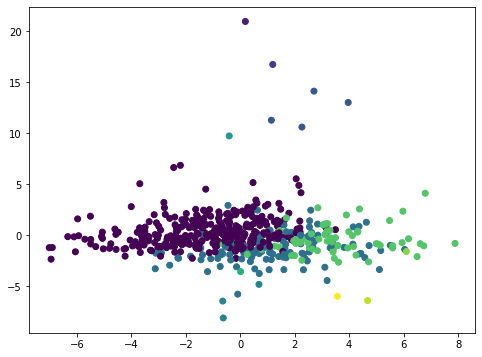

In [165]:
x_pca = PCA(n_components=2).fit_transform(df)
plt.figure(2, figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=class_index)

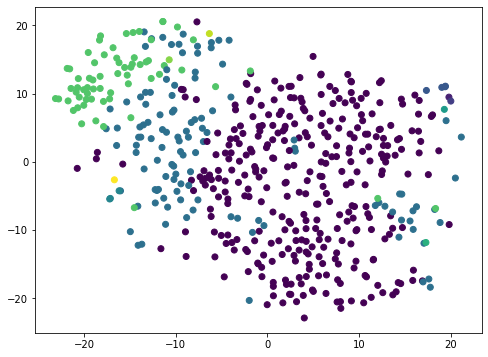

In [166]:
x_tsne = TSNE(n_components=2).fit_transform(df)

plt.figure(2, figsize=(8, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=class_index)

**То-ли я дурак, толи лыжи не едут. Но кластер, разделенный в ручную отличатеся от автоматическо разбивки.** это видно по картинке выше

In [167]:
len(classes_description)

12

In [168]:
from sklearn.metrics import v_measure_score, adjusted_rand_score
adjusted_rand_score(class_index, kmeans.labels_)

0.11769090877326192

Судя по доке

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

kmeans предсказал вообще не в попад, ниже привел вывод

In [169]:
for i in range(len(class_index)):
  print(class_index[i], kmeans.labels_[i])

0.0 1
0.0 1
0.0 7
0.0 0
0.0 1
0.0 4
0.0 4
0.0 7
0.0 7
0.0 7
1.0 5
2.0 5
3.0 10
0.0 7
0.0 7
0.0 7
0.0 6
0.0 11
0.0 7
0.0 7
0.0 2
0.0 1
0.0 1
0.0 4
0.0 1
0.0 6
0.0 4
0.0 4
0.0 2
0.0 4
0.0 7
0.0 4
0.0 4
0.0 4
0.0 2
0.0 7
0.0 7
0.0 4
0.0 4
0.0 4
0.0 4
0.0 4
0.0 4
0.0 4
0.0 4
0.0 7
0.0 4
0.0 4
0.0 1
0.0 9
0.0 4
0.0 7
0.0 4
0.0 7
0.0 7
0.0 7
0.0 4
0.0 7
0.0 11
0.0 2
0.0 4
0.0 4
0.0 7
0.0 4
0.0 4
0.0 4
0.0 4
0.0 4
0.0 1
0.0 4
0.0 7
4.0 6
0.0 11
0.0 4
0.0 4
0.0 7
0.0 8
0.0 8
5.0 3
0.0 6
0.0 6
0.0 7
4.0 6
4.0 9
4.0 3
4.0 6
4.0 9
4.0 8
4.0 6
4.0 1
4.0 6
4.0 6
4.0 6
4.0 6
0.0 2
0.0 4
4.0 3
4.0 8
0.0 6
0.0 8
0.0 7
0.0 6
0.0 7
0.0 7
0.0 7
4.0 6
0.0 4
0.0 0
0.0 6
0.0 7
0.0 8
0.0 11
0.0 6
0.0 6
0.0 11
0.0 6
0.0 2
4.0 6
4.0 9
4.0 8
0.0 7
0.0 8
4.0 9
4.0 9
0.0 7
4.0 8
0.0 4
4.0 9
4.0 8
0.0 4
0.0 4
0.0 8
0.0 2
4.0 6
0.0 4
0.0 4
0.0 2
0.0 2
0.0 2
0.0 4
0.0 7
0.0 8
4.0 9
4.0 8
4.0 8
4.0 7
4.0 7
0.0 7
6.0 7
4.0 2
0.0 1
4.0 8
0.0 1
0.0 8
0.0 1
0.0 1
4.0 8
4.0 8
4.0 8
0.0 7
0.0 6
0.0 2
4.0 1
4.0 8
4.0 1
0.0 

In [205]:
df2 = pd.DataFrame(columns=['a', 'b', 'c'])
df2.loc[len(df2)] = [1, 2, 3]
df2.loc[len(df2)] = [10, 20, 30]
df2.loc[len(df2)]=[100, 200, 300]
df2

,a,b,c
0,1,2,3
1,10,20,30
2,100,200,300


In [187]:
a = 'fadsf'
b = 'af'
print(f'{a:10} {b}')

fadsf      af


In [212]:
df2 = pd.DataFrame(columns=['eps', 'min_samples', 'adjusted_rand_score', 'v_measure_score'])
from sklearn.cluster import DBSCAN
for poww in range(-10, 10):
  for samples in range(2, 10):
    eps = 10**poww
    dbscan = DBSCAN(eps=eps, min_samples=samples).fit(df)
    df2.loc[len(df2)] = [eps, samples, adjusted_rand_score(class_index, dbscan.labels_), v_measure_score(class_index, dbscan.labels_)]
print_full(df2)


     eps  min_samples  adjusted_rand_score  v_measure_score
88  10.0          2.0             0.051161         0.150910
89  10.0          3.0             0.051161         0.150910
90  10.0          4.0             0.057306         0.148325
91  10.0          5.0             0.057306         0.148325
92  10.0          6.0             0.057306         0.148325
93  10.0          7.0             0.057306         0.148325
94  10.0          8.0             0.057306         0.148325
95  10.0          9.0             0.057306         0.148325


Более адекватные данные получил тут

In [213]:
print_full(df2.loc[(df2['adjusted_rand_score'] > 0)])

     eps  min_samples  adjusted_rand_score  v_measure_score
88  10.0          2.0             0.051161         0.150910
89  10.0          3.0             0.051161         0.150910
90  10.0          4.0             0.057306         0.148325
91  10.0          5.0             0.057306         0.148325
92  10.0          6.0             0.057306         0.148325
93  10.0          7.0             0.057306         0.148325
94  10.0          8.0             0.057306         0.148325
95  10.0          9.0             0.057306         0.148325
